In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
from sklearn.preprocessing import StandardScaler

In [2]:
# Load datasets
fraud_data = pd.read_csv('../src/data/Fraud_Data.csv')
ip_to_country = pd.read_csv('../src/data/IpAddress_to_Country.csv')
creditcard = pd.read_csv('../src/data/creditcard.csv')

In [4]:
# Display the first few rows of each dataset
print("Fraud Data:")
print(fraud_data.head())
print("\nIP to Country Data:")
print(ip_to_country.head())
print("\nCredit Card Data:")
print(creditcard.head())

Fraud Data:
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  

IP to Country Data:
   lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0   

Handle Missing Values

In [ ]:

# Impute missing values in Fraud_Data.csv
fraud_data['age'].fillna(fraud_data['age'].median(),)
fraud_data['device_id'].fillna('unknown', )
fraud_data['browser'].fillna('unknown', )
fraud_data['source'].fillna('unknown', )

0            SEO
1            Ads
2            SEO
3            SEO
4            Ads
           ...  
151107       SEO
151108       SEO
151109       SEO
151110       SEO
151111    Direct
Name: source, Length: 151112, dtype: object

In [7]:
# Check for missing values in creditcard.csv
print("\nMissing values in creditcard data:")
print(creditcard.isnull().sum())


Missing values in creditcard data:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Data Cleaning

In [8]:
# Remove duplicates
fraud_data = fraud_data.drop_duplicates()
creditcard = creditcard.drop_duplicates()

In [9]:
# Correct data types
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

In [10]:
# Convert IP addresses to integers for merging
def ip_to_int(ip):
    try:
        return int(ipaddress.IPv4Address(ip))
    except:
        return np.nan

fraud_data['ip_address_int'] = fraud_data['ip_address'].apply(ip_to_int)

Exploratory Data Analysis (EDA)

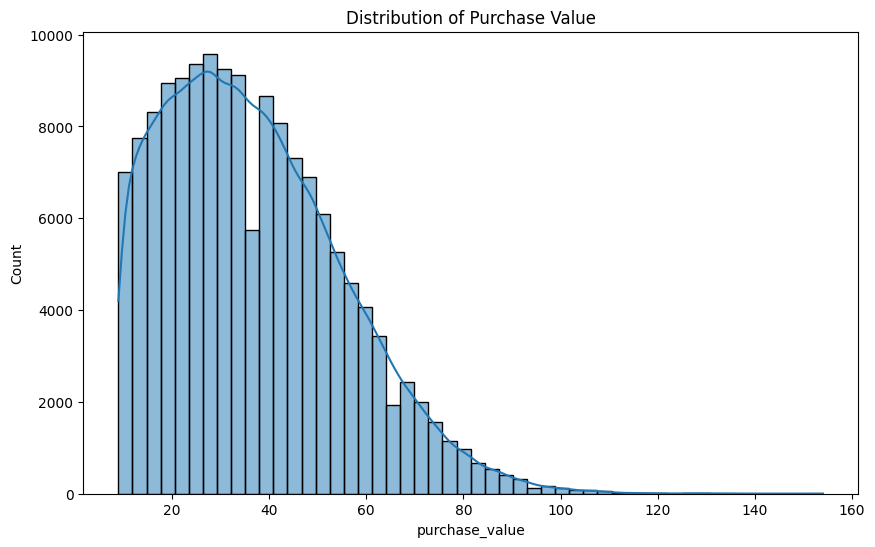

In [16]:
# Univariate Analysis
# Distribution of purchase_value
plt.figure(figsize=(10, 6))
sns.histplot(fraud_data['purchase_value'], bins=50, kde=True)
plt.title('Distribution of Purchase Value')
plt.show()

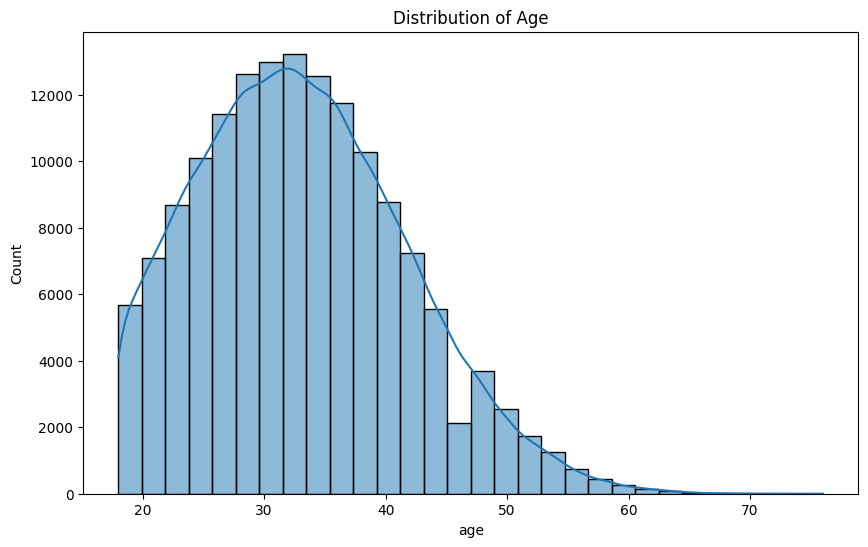

In [17]:
# Distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(fraud_data['age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.show()

In [18]:
# Class imbalance check
fraud_rate = fraud_data['class'].mean()
print(f"\nFraud Rate: {fraud_rate:.2%}")


Fraud Rate: 9.36%


In [19]:
# Bivariate Analysis
# Fraud rate by browser
fraud_rate_browser = fraud_data.groupby('browser')['class'].mean().sort_values(ascending=False)
print("\nFraud Rate by Browser:")
print(fraud_rate_browser)



Fraud Rate by Browser:
browser
Chrome     0.098792
FireFox    0.095165
Safari     0.090201
Opera      0.089227
IE         0.086775
Name: class, dtype: float64


In [20]:
# Fraud rate by source
fraud_rate_source = fraud_data.groupby('source')['class'].mean().sort_values(ascending=False)
print("\nFraud Rate by Source:")
print(fraud_rate_source)


Fraud Rate by Source:
source
Direct    0.105370
Ads       0.092066
SEO       0.089285
Name: class, dtype: float64


Merge Datasets for Geolocation Analysis

In [21]:
# Convert IP ranges in IpAddress_to_Country.csv to integers
ip_to_country['lower_bound'] = ip_to_country['lower_bound_ip_address'].apply(ip_to_int)
ip_to_country['upper_bound'] = ip_to_country['upper_bound_ip_address'].apply(ip_to_int)

In [22]:
# Map Fraud_Data IPs to countries
def get_country(ip_int):
    mask = (ip_to_country['lower_bound'] <= ip_int) & (ip_to_country['upper_bound'] >= ip_int)
    match = ip_to_country[mask]
    return match['country'].iloc[0] if not match.empty else np.nan

fraud_data['country'] = fraud_data['ip_address_int'].apply(get_country)

Feature Engineering

In [23]:
# Time-Based Features
fraud_data['purchase_hour'] = fraud_data['purchase_time'].dt.hour
fraud_data['purchase_day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
fraud_data['account_age_hours'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600

In [24]:
# Transaction Frequency/Velocity
fraud_data = fraud_data.sort_values(['user_id', 'purchase_time'])
fraud_data['transaction_count'] = fraud_data.groupby('user_id').cumcount() + 1
fraud_data['time_since_last_txn'] = fraud_data.groupby('user_id')['purchase_time'].diff().dt.total_seconds() / 3600

Normalization and Scaling

In [28]:
# Scale numerical features
scaler = StandardScaler()
fraud_data[['purchase_value_scaled']] = scaler.fit_transform(fraud_data[['purchase_value']])
creditcard['Amount_scaled'] = scaler.fit_transform(creditcard[['Amount']])

Encode Categorical Features

In [29]:
# One-hot encode categorical features
fraud_data = pd.get_dummies(
    fraud_data, 
    columns=['source', 'browser', 'sex', 'country'], 
    drop_first=True
)

Save Processed Data

In [30]:
fraud_data.to_csv('../src/data/fraud_data_processed.csv', index=False)
creditcard.to_csv('../src/data/creditcard_processed.csv', index=False)